In [1]:
import pandas as pd
import numpy as np
import hickle as hkl

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

7231.176539237286


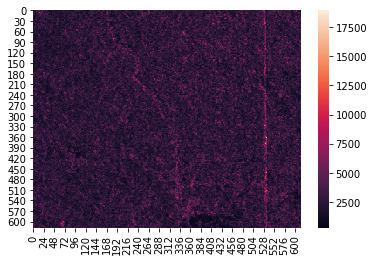

In [78]:
from skimage.transform import resize
s1 = hkl.load("../analysis/tifs/s12.hkl")
#i = np.load("tifs/interp.npy")
sns.heatmap(s1[3, :, :, 1])
print(np.mean(s1))

In [76]:
?resize

In [77]:
s1 = s1.reshape((s1.shape[0], s1.shape[1] // 2, 2, s1.shape[2] // 2, 2, 2))
s1 = np.mean(s1, (2, 4))
s1 = resize(s1, (s1.shape[0], s1.shape[1] * 2, s1.shape[2] * 2, 2), order = 1)
print(np.mean(s1))

7231.265115033489


In [55]:
#sns.heatmap(s1[0, :, :, 1])
s2 = resize(s2, (s2.shape[0], s2.shape[1] * 2, s2.shape[2] * 2, s2.shape[-1]), order = 1, preserve_range = True,
           anti_aliasing = False, )

In [60]:
sentinel2 = np.empty((s2.shape[0],  s2.shape[1] * 2, s2.shape[2] * 2, 10))
for band in range(6):
        for time in range(sentinel2.shape[0]):
            sentinel2[time, ..., band + 4] = resize(s2[time,..., band], (s2.shape[1] * 2,  s2.shape[2] * 2), 1)

<AxesSubplot:>

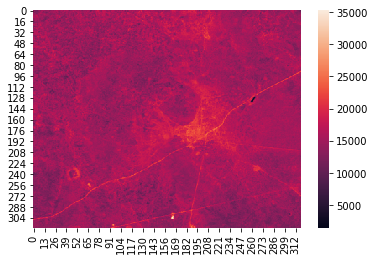

In [61]:
sns.heatmap(s2[3, :, :, 1])

In [187]:
shadow = np.load("tifs/shadow.npy")
cloud = np.load("tifs/cloud.npy")

<AxesSubplot:>

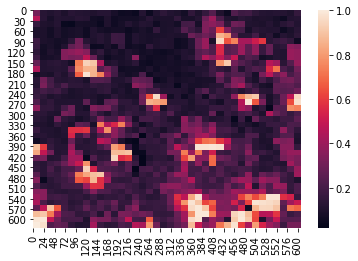

In [210]:
sns.heatmap(cloud[22])

In [213]:
sns.heatmap(shadow[22, ..., 6])

IndexError: index 6 is out of bounds for axis 3 with size 6

In [222]:
def mcm_shadow_mask(arr: np.ndarray, 
                    c_probs: np.ndarray) -> np.ndarray:
    """ Calculates the multitemporal shadow mask for Sentinel-2 using
        the methods from Candra et al. 2020 on L1C images and matching
        outputs to the s2cloudless cloud probabilities

        Parameters:
         arr (arr): (Time, X, Y, Band) array of L1C data scaled from [0, 1]
         c_probs (arr): (Time, X, Y) array of S2cloudless cloud probabilities
        Returns:
         shadows_new (arr): cloud mask after Candra et al. 2020 and cloud matching 
         shadows_original (arr): cloud mask after Candra et al. 2020
    """
    import time
    imsize = arr.shape[1]

    if imsize % 8 != 0:
        pad_amt = 1 #int((imsize % 8) // 2)

        arr = np.pad(arr, ((0, 0), (pad_amt, pad_amt), (pad_amt, pad_amt), (0, 0)))
        c_probs = np.pad(c_probs, ((0, 0), (pad_amt, pad_amt), (pad_amt, pad_amt)))

    assert arr.dtype == np.uint16
    assert arr.shape[1] == c_probs.shape[1]
    size = arr.shape[1]

    # Create empty arrays for shadows, clouds
    shadows = np.empty_like(arr)[..., 0]
    clouds = np.empty_like(shadows)
    # Iterate through time steps, develop local reference images
    # and calculate cloud/shadow based on Candra et al. 2020
    for time in range(arr.shape[0]):
        lower = np.max([0, time - 3])
        upper = np.min([arr.shape[0], time + 4])
        ri = np.median(arr[lower:upper], axis = 0).astype(np.float32)
        
            

        deltab2 = (arr[time, ..., 0] - ri[..., 0]) > int(0.10 * 65535)
        deltab8a = (arr[time, ..., 3] - ri[..., 3]) < int(-0.06 * 65535)
        deltab11 = (arr[time, ..., 5] - ri[..., 5]) < int(-0.06 * 65535)
        deltab3 = (arr[time, ..., 1] - ri[..., 1]) > int(0.08 * 65535)
        deltab4 = (arr[time, ..., 2] - ri[..., 2]) > int(0.08 * 65535)
        ti0 = arr[time, ..., 0] < int(0.095 * 65535)
        ti10 = arr[time, ..., 4] > int(0.01 * 65535)
        clouds_i = (deltab2 * deltab3 * deltab4) + ti10
        clouds_i = clouds_i * 1
        clouds_i[clouds_i > 1] = 1.

        shadows_i = ((1 - clouds_i) * deltab11 * deltab8a * ti0)
        shadows_i = shadows_i * 1

        clouds[time] = clouds_i
        shadows[time] = shadows_i
        if time == 22:
            ri_out = ri

    # Iterate through clouds, shadows, remove cloud/shadow where
    # The same px is positive in subsequent time steps (likely FP)
    clouds_new = np.copy(clouds)
    for time in range(1, clouds.shape[-1], 1):
        moving_sums = np.sum(clouds[time - 1:time + 2], axis = (0))
        moving_sums = moving_sums >= 3
        clouds_new[time - 1:time + 2, moving_sums] = 0.
    clouds = clouds_new

    # Remove shadows if multiple time steps are shadows
    shadows_new = np.copy(shadows)
    for time in range(1, shadows.shape[-1], 1):
        moving_sums = np.sum(shadows[time - 1:time + 1], axis = 0)
        moving_sums = moving_sums >= 2
        if np.sum(moving_sums > 0):
        	print(f"Removing {np.sum(moving_sums)}, time {time}")
        shadows_new[time - 1:time + 1, moving_sums] = 0.
    shadows = shadows_new
    print(np.sum(shadows), np.sum(clouds))

    # Combine cloud and shadow
    shadows = shadows + clouds
    shadows[shadows > 1] = 1.
    return shadows, ri_out

shadows, ri = mcm_shadow_mask(shadow, cloud)

Removing 512, time 19
Removing 3328, time 20
Removing 256, time 21
116992 303872


<AxesSubplot:>

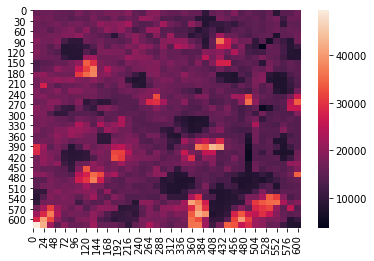

In [268]:
sns.heatmap(shadow[22, ..., 3])

<AxesSubplot:>

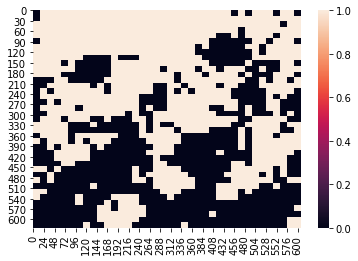

In [275]:
sns.heatmap(shadow[22, ..., 0] <  int(0.119 * 65535))

<AxesSubplot:>

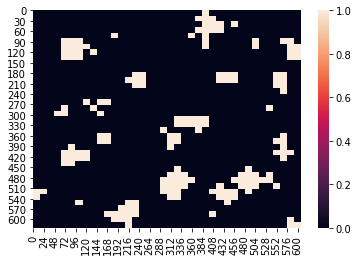

In [259]:
deltab8a = (shadow[22, ..., 3] - ri[..., 3]) < int(-0.06 * 65535)
deltab11 = (shadow[22, ..., 5] - ri[..., 5]) < int(-0.06 * 65535)
ti0 = shadow[22, ..., 0] < int(0.12 * 65535)

sns.heatmap(deltab11 * deltab8a * ti0)

In [253]:
np.min(shadow[22,...,  0])

6783

<AxesSubplot:>

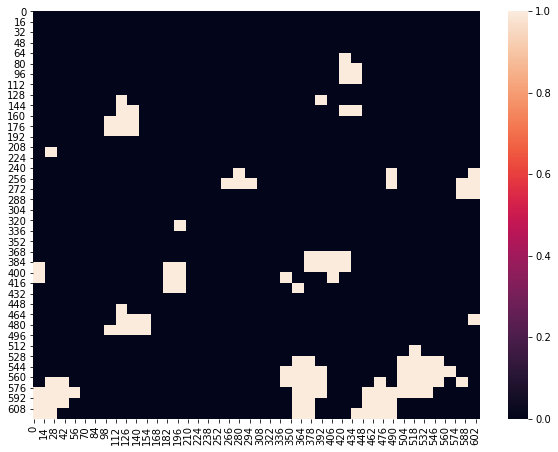

In [182]:
plt.figure(figsize=(10,7.5))
sns.heatmap(shadow[8, ...])

<AxesSubplot:>

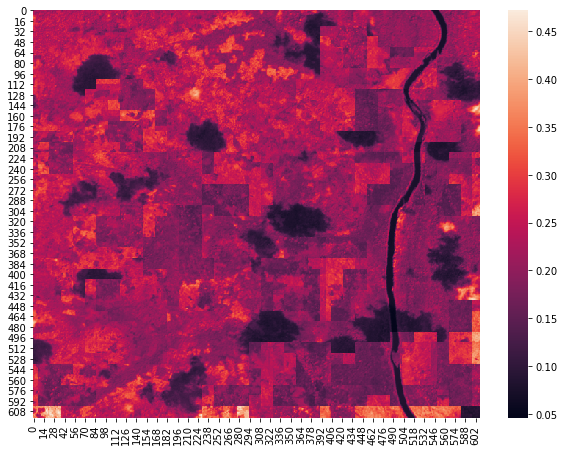

In [186]:
plt.figure(figsize=(10,7.5))
sns.heatmap(s2[6, :, 2:-2, 3])

<AxesSubplot:>

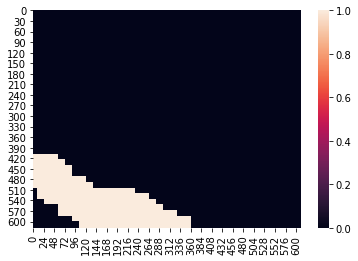

In [151]:
sns.heatmap(i[8])